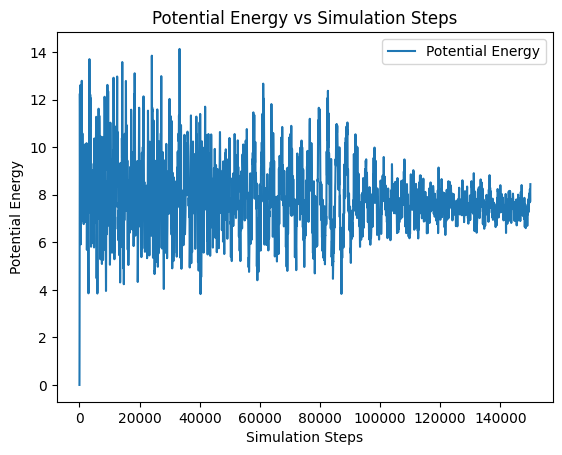

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.5  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()


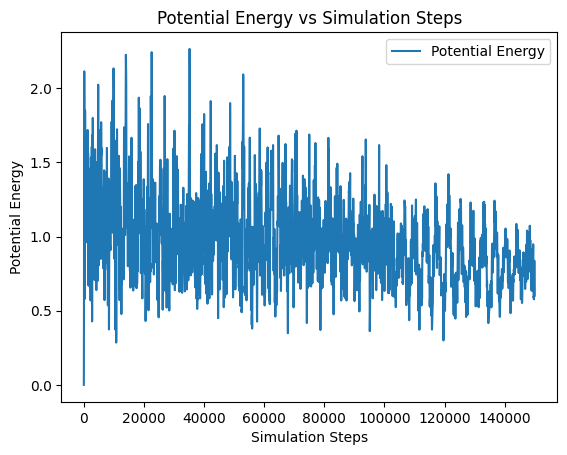

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()


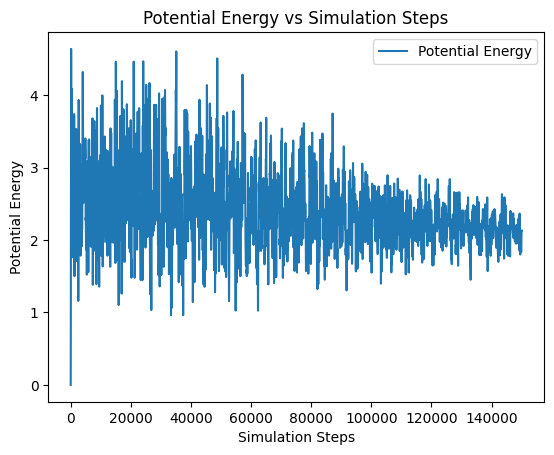

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.2  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()


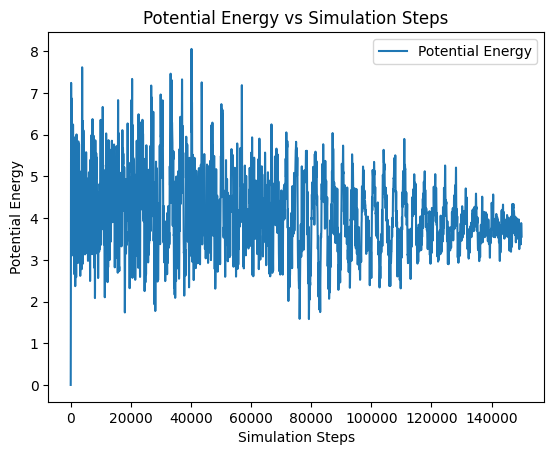

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.3  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()


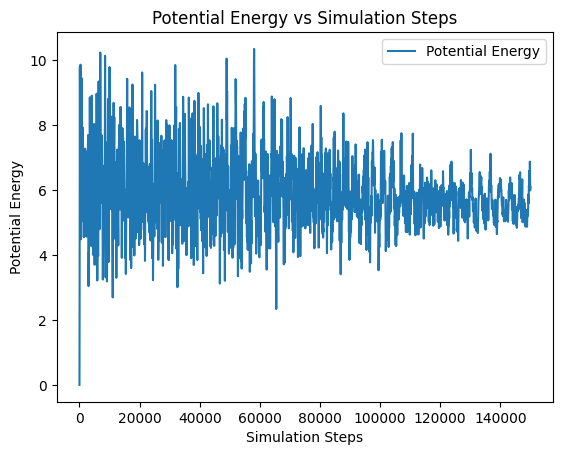

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.4  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()


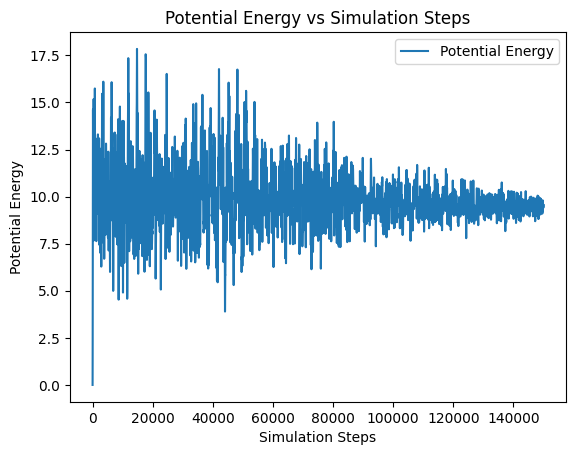

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.6  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()


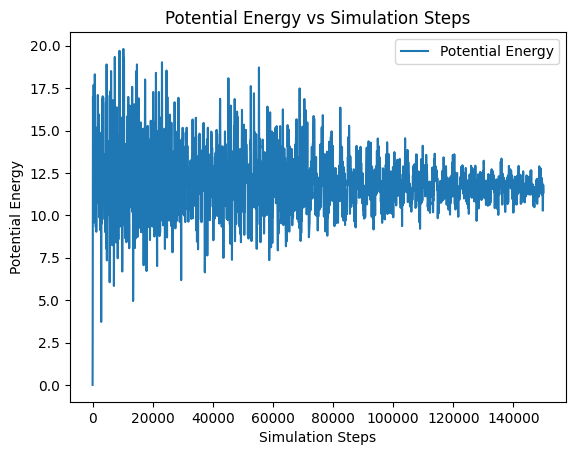

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.7  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()


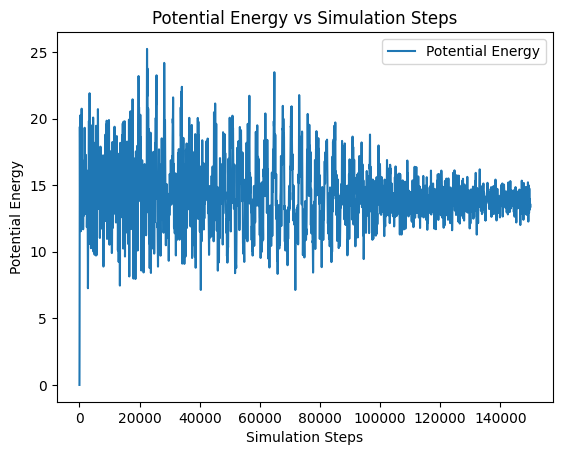

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.8  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()


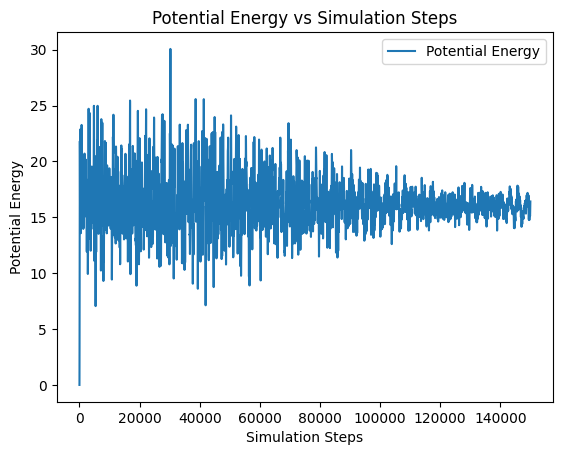

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.9  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()


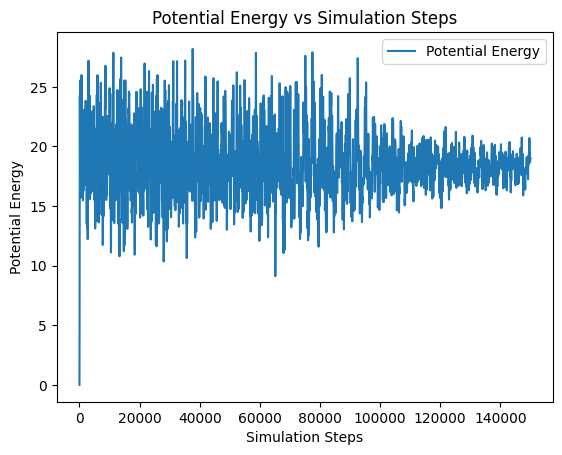

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 1.0  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# List to store potential energy at each step
potential_energies_steps = []

# Simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

    # Calculate potential energy for this step
    E_harmonic = 0.0
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        E_harmonic += 0.5 * k * (distance - r0)**2

    E_LJ = 0.0
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                if abs(i - j) == 2:
                    E_LJ += 4 * epsilon_repulsive * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif abs(i - j) > 2:
                    E_LJ += 4 * epsilon_attractive * ((sigma / distance)**12 - (sigma / distance)**6)

    potential_energy = E_harmonic + E_LJ
    potential_energies_steps.append(potential_energy)

    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

# Plot potential energy vs steps
plt.figure()
plt.plot(range(total_steps), potential_energies_steps, label='Potential Energy')
plt.xlabel('Simulation Steps')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Simulation Steps')
plt.legend()
plt.show()
